In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import os 
import numpy as np
import pandas as pd 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
data = pd.read_csv('data.csv')

In [3]:
# print(data.shape)

In [4]:
# converting to tensor
data = torch.tensor(data.values)
data = data.float()

In [5]:
# CONSTANTS
N_EPOCHS = 500           
INPUT_DIM = 9           
HIDDEN_DIM = 7         
LATENT_DIM = 4           
lr = 1e-4 

In [6]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.var = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        # non linear function of input
        hidden = F.relu(self.linear(x))
       
        # mean of latent variable distribution
        z_mu = self.mu(hidden)

        # variance of latent variable distribution
        log_z_var = self.var(hidden)

        return z_mu, log_z_var

In [7]:
# Decoder
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim):
        super().__init__()

        self.linear = nn.Linear(z_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # non linear function of latent variable
        hidden = F.relu(self.linear(x))

        predicted = self.out(hidden)

        return predicted

In [8]:
class VAE(nn.Module):
    def __init__(self, enc, dec):
        super().__init__()

        self.enc = enc
        self.dec = dec

    def forward(self, x):
        # encode the input, generate mean and variance of latent variable distribution
        z_mu, z_var = self.enc(x)

        # standard deviation
        std = torch.exp(z_var / 2)
        # small epsilon value sampled from N(0,I) of size same as std
        eps = torch.randn_like(std)
        
        # sample from the distribution having latent parameters z_mu, z_var
        # using reparametrisation trick to simplify gradient descent
        x_sample = eps.mul(std).add_(z_mu)

        # decode the sample
        predicted = self.dec(x_sample)

        return predicted, z_mu, z_var
    
    
    def gen(self, x):
        z_mu, z_var = self.enc(x)

        std = torch.exp(z_var / 2)
        # small epsilon value sampled from N(0,I) of size same as std
        eps = torch.randn_like(std)

        # generate new sample from the distribution having latent parameters z_mu, z_var
        # using reparametrisation trick to simplify gradient descent
        x_sample = eps.mul(std).add_(z_mu)
        
        return x_sample

In [9]:
# encoder
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)

In [10]:
# decoder
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)

In [11]:
# vae
model = VAE(encoder, decoder)

In [12]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [13]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0

    for i in range(list(data.size())[0]):
        x = data[i,:]

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        x_sample, z_mu, log_z_var = model(x)

        # reconstruction loss, squared loss
        recon_loss = torch.sum((x-x_sample)**2)
        # print(recon_loss)

        # kl divergence loss
        kl_loss = 0.5 * torch.sum(torch.exp(log_z_var) + z_mu**2 - 1.0 - log_z_var)
        # print(kl_loss)
        
        # total loss
        loss = recon_loss + kl_loss

        # backward propagation
        loss.backward()

        # adding total loss
        train_loss += loss.item()
        # print(train_loss)

        # update the weights of NN
        optimizer.step()

    return train_loss

In [14]:
# # CONSTANTS
# N_EPOCHS = 500     
# INPUT_DIM = 9           
# HIDDEN_DIM = 7         
# LATENT_DIM = 4           
# lr = 1e-4 

In [15]:
# HIDDEN_DIMS = [5, 6, 7, 8]
# LATENT_DIMS = [4, 5, 6]
# for hidden_dim in HIDDEN_DIMS:
#     for latent_dim in LATENT_DIMS:
#         print(hidden_dim, latent_adim)
#         HIDDEN_DIM = hidden_dim
#         LATENT_DIM = latent_dim
#         # encoder
#         encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)
#         # decoder
#         decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)
#         # vae
#         model = VAE(encoder, decoder)
#         # optimizer
#         optimizer = optim.Adam(model.parameters(), lr=lr)
#         for epoch in range(N_EPOCHS):
#             train_loss = train()
#             train_loss /= list(data.size())[0]
# #     print('Epoch %d, Train Loss: %.2f'%(epoch, train_loss))
#             print("%.2f"%(train_loss), end=' ')
#         print()

In [16]:
# train for N_EPOCHS
for epoch in range(N_EPOCHS):
    train_loss = train()
    train_loss /= list(data.size())[0]
    print("%.2f"%(train_loss), end=' ')

5.41 4.27 3.64 3.31 3.15 3.02 2.97 2.91 2.87 2.83 2.81 2.79 2.78 2.77 2.78 2.76 2.76 2.73 2.74 2.73 2.72 2.70 2.66 2.72 2.71 2.65 2.66 2.65 2.66 2.66 2.63 2.66 2.62 2.63 2.62 2.66 2.63 2.63 2.59 2.62 2.65 2.60 2.58 2.60 2.67 2.61 2.58 2.63 2.62 2.55 2.68 2.58 2.66 2.62 2.60 2.63 2.62 2.60 2.60 2.62 2.61 2.60 2.61 2.56 2.54 2.59 2.60 2.59 2.59 2.60 2.57 2.56 2.61 2.55 2.63 2.54 2.59 2.61 2.58 2.59 2.59 2.55 2.54 2.56 2.53 2.57 2.53 2.58 2.59 2.53 2.60 2.51 2.55 2.55 2.57 2.55 2.59 2.53 2.49 2.52 2.53 2.56 2.49 2.54 2.54 2.53 2.52 2.55 2.49 2.53 2.52 2.55 2.51 2.50 2.51 2.52 2.50 2.54 2.53 2.50 2.53 2.50 2.55 2.52 2.51 2.53 2.48 2.56 2.51 2.53 2.54 2.54 2.53 2.49 2.54 2.51 2.50 2.46 2.51 2.48 2.50 2.51 2.51 2.49 2.54 2.51 2.48 2.52 2.51 2.49 2.52 2.49 2.47 2.50 2.50 2.51 2.51 2.47 2.46 2.48 2.48 2.49 2.48 2.50 2.45 2.50 2.45 2.48 2.48 2.50 2.47 2.48 2.47 2.46 2.46 2.50 2.47 2.45 2.46 2.49 2.44 2.44 2.51 2.50 2.45 2.45 2.42 2.49 2.47 2.46 2.46 2.48 2.47 2.38 2.43 2.41 2.44 2.45 2.41 2.46 

In [17]:
new_X = np.zeros((data.shape[0], LATENT_DIM), dtype=float)
print(data[0,:].shape)
for i in range(list(data.size())[0]):
    x = data[i,:]
    x_sample = model.gen(x)
    x_sample_np = x_sample.detach().numpy()
    new_X[i] = x_sample_np

torch.Size([9])


In [18]:
print(data.shape)
print(new_X.shape)

torch.Size([1163, 9])
(1163, 4)


In [ ]:
# new_data = pd.DataFrame(new_X, columns = ['P1', 'P2', 'P3', 'P4'])
# new_data.to_csv('new_data.csv')

In [ ]:
# data = pd.read_csv('new_data.csv')

In [19]:
# new_X = data.values

In [20]:
# K means clustering
K = range(2, 50)

In [21]:
inertias = [] 

for k in K: 
    #Building and fitting the model 
    kmeans_model = KMeans(n_clusters=k)
    kmeans_model.fit(new_X)     
    inertias.append(kmeans_model.inertia_) 

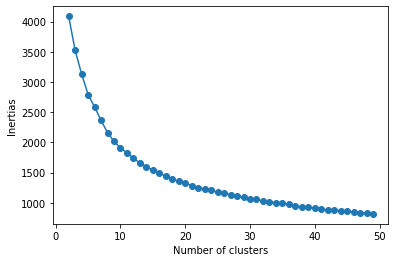

In [22]:
plt.plot(K, inertias, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertias")
plt.show()

In [23]:
kmeans_model = KMeans(n_clusters=10).fit(new_X)

In [24]:
Counter(kmeans_model.labels_)

Counter({5: 108,
         7: 132,
         3: 145,
         9: 148,
         4: 140,
         2: 153,
         0: 124,
         1: 106,
         6: 106,
         8: 1})

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X = scaler.fit_transform(new_X)

print(scaler.mean_)

[ 0.01278498 -0.032408    0.04315907 -0.04779849]


In [27]:
inertias = [] 

for k in K: 
    #Building and fitting the model 
    kmeans_model = KMeans(n_clusters=k)
    kmeans_model.fit(scaled_X)     
    inertias.append(kmeans_model.inertia_) 

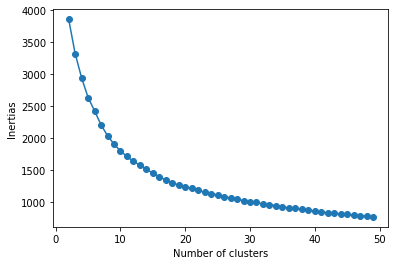

In [28]:
plt.plot(K, inertias, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertias")
plt.show()

In [29]:
kmeans_model = KMeans(n_clusters=20).fit(scaled_X)

In [30]:
Counter(kmeans_model.labels_)

Counter({17: 56,
         7: 58,
         14: 49,
         1: 86,
         0: 48,
         13: 67,
         11: 50,
         6: 108,
         15: 57,
         5: 57,
         16: 56,
         2: 71,
         12: 57,
         18: 59,
         3: 57,
         10: 63,
         19: 58,
         9: 62,
         8: 43,
         4: 1})

In [31]:
df = pd.read_csv('data.csv')
X = df.values

In [32]:
inertias = [] 

for k in K: 
    #Building and fitting the model 
    kmeans_model = KMeans(n_clusters=k)
    kmeans_model.fit(X)     
    inertias.append(kmeans_model.inertia_) 

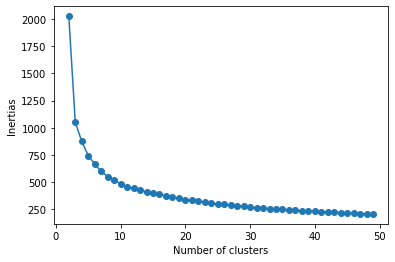

In [33]:
plt.plot(K, inertias, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertias")
plt.show()

In [34]:
kmeans_model = KMeans(n_clusters=10).fit(X)

In [35]:
Counter(kmeans_model.labels_)

Counter({6: 143,
         9: 106,
         4: 177,
         0: 123,
         1: 112,
         8: 232,
         3: 193,
         7: 74,
         5: 2,
         2: 1})

In [36]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

print(scaler.mean_)

[ 0.959524    0.85616583  0.2161109   0.14919403  0.60036861  0.52484523
  0.00098841 -0.00269966 -0.02701196]


In [37]:
inertias = [] 

for k in K: 
    #Building and fitting the model 
    kmeans_model = KMeans(n_clusters=k)
    kmeans_model.fit(scaled_X)    
    inertias.append(kmeans_model.inertia_) 

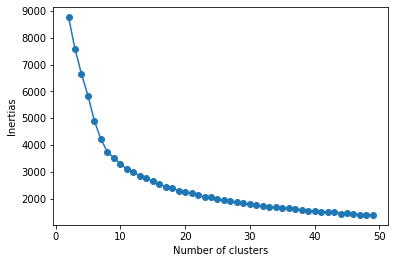

In [38]:
plt.plot(K, inertias, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertias")
plt.show()

In [39]:
kmeans_model = KMeans(n_clusters=9).fit(scaled_X)

In [40]:
Counter(kmeans_model.labels_)

Counter({8: 95, 7: 186, 0: 259, 6: 272, 1: 211, 5: 29, 2: 108, 3: 2, 4: 1})